## Demand Forecasting Model
Developing a demand forecasting model using historical sales data


In [8]:
import pandas as pd
import requests
from io import StringIO
import certifi
import matplotlib.pyplot as plt
from prophet import Prophet

In [9]:
# Define the Google Drive link and convert it to a direct download link
csv_url = 'https://drive.google.com/file/d/1GB-if5xcQM64dV4O6_H-HjcgOK21Z9j2/view?usp=sharing'
file_id = csv_url.split('/')[-2]
dwn_url = f'https://drive.google.com/uc?id={file_id}'

# Get the CSV data with SSL verification
response = requests.get(dwn_url, verify=certifi.where()).text

# Load the CSV content directly into a pandas DataFrame without saving it
csv_raw = StringIO(response)
data = pd.read_csv(csv_raw)
data['Invoice Date'] = pd.to_datetime(data['Invoice Date'])


In [10]:
# Group data by date and filter by choice of StockCode
stockcode = '84879'
daily_demand = data.groupby(['Invoice Date', 'StockCode'])['Quantity'].sum().reset_index()
product_data = daily_demand[daily_demand['StockCode'] == stockcode]

# Set index and resample to weekly data
product_data.set_index('Invoice Date', inplace=True)
weekly_sales = product_data['Quantity'].resample('W').sum().reset_index()
weekly_sales.columns = ['ds', 'y']  # Rename columns for Prophet

## Model of choice

I experimented several models like ARIMA, SARIMA, STL + Naive, Prophet.
<br><br>
Upon evaluation, Prophet model gave the best results

02:17:45 - cmdstanpy - INFO - Chain [1] start processing
02:17:45 - cmdstanpy - INFO - Chain [1] done processing


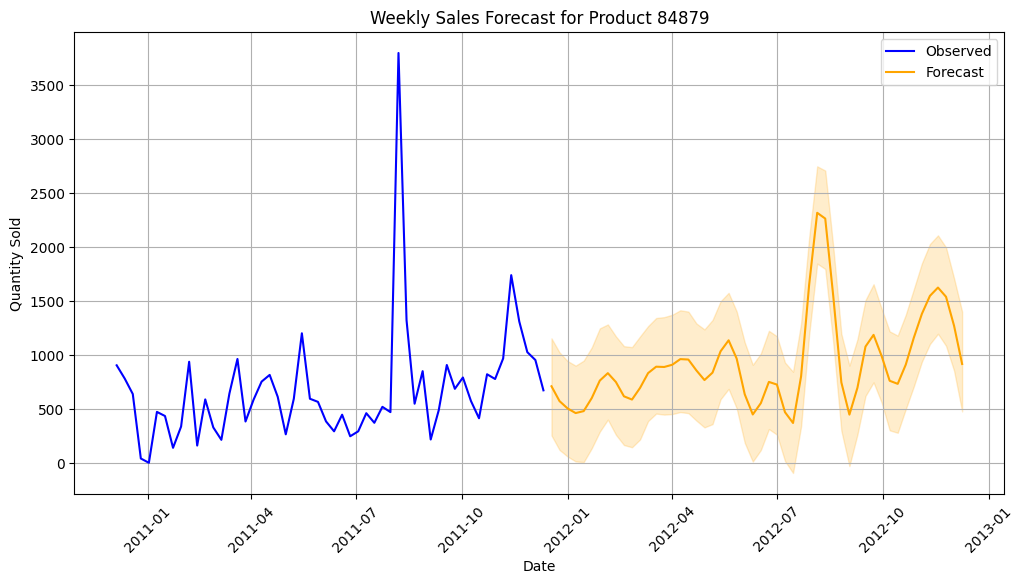

In [11]:
# Initialize and fit Prophet model on observed data
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(weekly_sales)

# Create future dates for forecast (only beyond observed data)
future_dates = model_prophet.make_future_dataframe(periods=52, freq='W')
forecast_prophet = model_prophet.predict(future_dates)

# Calculate the bias based on the initial portion of the forecast vs the last observed values
observed_mean = weekly_sales['y'][-10:].mean()  # Average of the last 10 observed values
forecast_future_mean = forecast_prophet['yhat'][len(weekly_sales):].mean()  # Mean of the future forecasted values

# Calculate bias correction based on the difference
# prophet model takes into account the trend, which is upwards in this case
# this is undesirable in this scenario of sales since we only want to capture the seasonality/pattern
# Hence the need for bias correction 
bias = forecast_future_mean - observed_mean

# Apply bias correction only to the forecasted values after the observed period
forecast_prophet.loc[len(weekly_sales):, 'yhat_adjusted'] = forecast_prophet.loc[len(weekly_sales):, 'yhat'] - bias

# Plot observed data and adjusted forecast
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales['ds'], weekly_sales['y'], label='Observed', color='blue')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat_adjusted'], label='Forecast', color='orange')
plt.fill_between(forecast_prophet['ds'], 
                 forecast_prophet['yhat_lower'] - bias, 
                 forecast_prophet['yhat_upper'] - bias, 
                 color='orange', alpha=0.2, where=(forecast_prophet['ds'] > weekly_sales['ds'].max()))
plt.title(f'Weekly Sales Forecast for Product {stockcode}')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


## Conclusion
By forecasting demand for each product, we can predict and visualize demand variability, which plays a crucial role in optimizing inventory. Products with higher demand variability require closer monitoring and more frequent replenishment to avoid stockouts. To demonstrate this, we developed an inventory optimization algorithm, which confirms that products with higher demand and greater variability indeed impact stock levels and reorder strategies.